## CNN for image classification on the Fashion MNIST Data set
This notebook follows the notebook done on the Fasion MNIST classification using a forward feed (squential) neural network to try and get better classification accuracy then we saw there for the one hidden layer. (Note alot of the text here that follows comes from and has been editted from the Nvidia fundamential of deep learning workshop on ASL image classifiation tutorials.

In [1]:
# Normal Sci. Comp. Imports
import numpy as np
import matplotlib.pyplot as plt
# create random number generator for later/throughout (seed is my birthday digits)
rng = np.random.default_rng(seed=120695)
import pandas as pd
import tensorflow.keras as keras

Now lets look the fashion mnist data set. The data consists of 70,000 images of fashion items. The partition of the data set is such that the training data set contains 60,000 images and the testing data set contains the other 10,000. Each images is a 28 by 28 2D array of integer values. There is only 10 labels. We will split the training data set further to have a validation set consisting of the final 12000 images in the training data sets so as two have a 80% to 20% split. 

In [2]:
# Load the keras data set module:
from tensorflow.keras.datasets import fashion_mnist
# with fashion mnist model data is already partitioned into training and validation
(X, Y), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid = X[:48000], X[48000:]
y_train, y_valid = Y[:48000], Y[48000:]

## Reshaping Images for a CNN
In the previous case, we feed the NN a long list of 784 pixel values. To do this we first had to reshape/resize each image. For the CNN we will have to do some reshaping but will keep the images as a 28 by 28 2D array of pixel values. When we were reshaping the original image into a long of 784 pixels we lose imformation about which pixels are near/next to each other and thus we cannot apply convolutions that will detect features. By keeping the images as 28 by 28 2D arrays for pixel values, the convolutions that are applied will be apply to detect and pick up features of the data, such as edges, by being able to associate neighboring and groups of pixels. We will not have to do the same for the labels as they are just integer value that correspond to an article of clothing/fashion as such
* 0=T-shirt/top
* 1=Trouser
* 2=Pullover
* 3=Dress
* 4=Coat
* 5=Sandal
* 6=Shirt
* 7=Sneaker
* 8=Bag
* 9=Ankle boot

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Since the Fashion MNIST data set image are greyscale, the number of channels will be 1. Do note though that the number of channels can be 3 or 4 for rgb images.

In [3]:
idx = rng.integers(low=0, high=x_train.shape[0])
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(f"x_train is now a {x_train.shape} shaped array")
print(f"x_valid is now a {x_valid.shape} shaped array")
print(f" and x_test is now a {x_test.shape} shaped array")
print(f"As an example here is the above 1D array of the above displayed image \n {x_train[idx, :, :, 0]}")

x_train is now a (48000, 28, 28, 1) shaped array
x_valid is now a (12000, 28, 28, 1) shaped array
 and x_test is now a (10000, 28, 28, 1) shaped array
As an example here is the above 1D array of the above displayed image 
 [[  0   0   0   0   0   0   0   0   0  43 111  54  40  29  22  29  38  88
  102  18   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   9  68 111 136 207 143 150 138 129 138 138 182
  173 129 113  50   6   0   0   0   0   0]
 [  0   0   0   0   0  50 129 138 104  95 166 136 116 136 152 157 118 152
  145  97 118 138 138  79   0   0   0   0]
 [  0   0   0   0  25 127 113 102 107  86 145 184 132 170 186 150 125 193
  134  93  97  95 107 138  50   0   0   0]
 [  0   0   0   0  66 118 104 109 104  93  93 175 175 125 129 118 161 186
   91  93 102  97 118 125  91   0   0   0]
 [  0   0   0   0 113 107  95 102 100  97  81 109 193 136 109 118 188 129
   91 107  95 100 154 104 116   4   0   0]
 [  0   0   0  11 132 107  86 100  95  93  91  81 120 182 173 177 132  91
 

## Normalized and Categorical Encodings
As with the normal FF NN, it is still suggested to normalize the data and categorically encode the data as a preprocesssing and prepatorial step. So like we did with the forward feed network, we will have normalized training, validation and testing set as well as categorically encoded and non-encoded data sets just to see the difference between the accuracy of the models that were trained on the differing combinations of normalization and encoding. So like before we will have 4 different models in the end:
1. A model that uses the normalized data and categorical encoding of the labels (i.e. norm_tr and y_tr_encoded)
2. Another model that uses the normalized data but the original data labels- no categorical encoding (i.e. norm_tr and y_train)
3. A model with non-normalized (original) data but with categorically encoded data (i.e. x_train and y_tr_encoded)
4. No simplification model; Non-normalized data and non-categorically encoded data labels (i.e. x_train and y_train)

In [4]:
# To normalize divide by 255 as the integer values are between 0 and 255
norm_tr = x_train / 255
norm_va = x_valid / 255
norm_tst = x_test / 255
# double check that the values are of type float and that they are between 0 and 1
print(f"Data type of normalized data: {norm_tr.dtype}\n Min of normalized: {norm_tr.min()} and max is {norm_tr.max()}")

Data type of normalized data: float64
 Min of normalized: 0.0 and max is 1.0


In [5]:
num_categories = len(np.unique(y_train))
# use the keras library/wrapper function to create the categories
y_tr_encoded = keras.utils.to_categorical(y_train, num_categories)
y_va_encoded = keras.utils.to_categorical(y_valid, num_categories)
y_tst_encoded = keras.utils.to_categorical(y_test, num_categories)

## Creating the CNN models
So there is no good starting place on what model to make but apparently today data scientists start there projects by borrowing model properties from similar project. So we have borrowed a model that works well for classifying images of American Sign Language (ASL) according to Nvidia. See the below image for a lay out of the model 

<img src="images/cnn.png" width=180 />

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
def CNN_FMNST_model():
    """
    Create a model for image classification of the fashion MNIST data set
    """
    model = Sequential()
    # add a 2d convolusional network with relu activation and input shape of 28X28 with 1 colour channel. 
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                     input_shape=(28, 28, 1)))
    # add normalization batch
    model.add(BatchNormalization())
    # add the max pooling layer
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_categories, activation="softmax"))
    return model

So like with the previous forward feed model that we created, we first create the the sequential model and then sequentially add layers. The first layer to add is the input layer which is a 2D convolusional layer. For each convolusional layer, a small kernal will go over the input image and detect features for classifying. By having more and more convolusional layers, the idea is that earlier one will pick up on simplier fearutes in the image while later ones will detect more complex features. Regarding the first convolusional layer 
```Python
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image and the other parameters are self explanatory. For a more detailed explanation of the function arguments than what follows see [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). In general the ```strides``` arguement specifies the strides along the height and width but with a singe integer argument value the the strides taken in each spatial dimension is the same. The ```padding``` with a values of 'same' pads the image with zeros evenly to the left/right or up/down of the input. When the ```padding="same"``` and ```strides=1```, the output has the same size as the input.



In [7]:
model1, model2, model3, model4 = CNN_FMNST_model(), CNN_FMNST_model(), CNN_FMNST_model(), CNN_FMNST_model()

### Summary of the models
Each of the 4 models are the exact same so we only print out the summary for one of them. Notice the total number of parameters and those that are trainable and not trainable. 

In [8]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 50)         

### Compile the model
So we have yet to give the model some sort of loss function for it to optimize against the parameters as well as metric to maximize. This is done when the model is [compiled](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile). There is a number of arguments to give the compile function but here only worry about the loss function and the metrics and leave the rest to there default values (though we may want to look into them). Now the matter of loss functions ther are a [number](https://keras.io/api/losses/) of them. At first will use the categorical cross entropy loss for the validation data that has been categorically encoded, in the one_hot format above and use the sparse categorical cross entroy for the other non categorically encoded labels as theses values are given as integers which this loss function expects. We also specify that we would like to track `accuracy` while the model trains, for other metrics see [here](https://keras.io/api/metrics/)

In [9]:
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model4.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history1 = model1.fit(
    norm_tr, y_tr_encoded, epochs=20, verbose=1, validation_data=(norm_va, y_va_encoded)
)

Epoch 1/20
1500/1500 [==============================] - 17s 10ms/step - loss: 0.4508 - accuracy: 0.8423 - val_loss: 0.2995 - val_accuracy: 0.8923
Epoch 2/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3237 - accuracy: 0.8862 - val_loss: 0.3027 - val_accuracy: 0.8968
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2908 - accuracy: 0.8983 - val_loss: 0.2864 - val_accuracy: 0.9010
Epoch 4/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2630 - accuracy: 0.9082 - val_loss: 0.3134 - val_accuracy: 0.8905
Epoch 5/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2431 - accuracy: 0.9122 - val_loss: 0.2558 - val_accuracy: 0.9072
Epoch 6/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2250 - accuracy: 0.9184 - val_loss: 0.2467 - val_accuracy: 0.9153
Epoch 7/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2073 - accuracy: 0.9244 - val_loss: 0.3002 -

In [12]:
history2 = model2.fit(
    norm_tr, y_train, epochs=20, verbose=1, validation_data=(norm_va, y_valid)
)

Epoch 1/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3901 - accuracy: 0.8611 - val_loss: 0.3215 - val_accuracy: 0.8803
Epoch 2/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3179 - accuracy: 0.8876 - val_loss: 0.3276 - val_accuracy: 0.8777
Epoch 3/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2866 - accuracy: 0.9005 - val_loss: 0.3421 - val_accuracy: 0.8741
Epoch 4/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2596 - accuracy: 0.9076 - val_loss: 0.2377 - val_accuracy: 0.9147
Epoch 5/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2343 - accuracy: 0.9162 - val_loss: 0.2506 - val_accuracy: 0.9092
Epoch 6/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2150 - accuracy: 0.9201 - val_loss: 0.2413 - val_accuracy: 0.9158
Epoch 7/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2001 - accuracy: 0.9276 - val_loss: 0.2209 -

In [13]:
history3 = model3.fit(
    x_train, y_tr_encoded, epochs=20, verbose=1, validation_data=(x_valid, y_va_encoded)
)

Epoch 1/20
1500/1500 [==============================] - 19s 12ms/step - loss: 0.4456 - accuracy: 0.8431 - val_loss: 0.3317 - val_accuracy: 0.8758
Epoch 2/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3236 - accuracy: 0.8875 - val_loss: 0.2909 - val_accuracy: 0.8976
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2879 - accuracy: 0.8995 - val_loss: 0.4089 - val_accuracy: 0.8662
Epoch 4/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2656 - accuracy: 0.9060 - val_loss: 0.2823 - val_accuracy: 0.8958
Epoch 5/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2436 - accuracy: 0.9130 - val_loss: 0.2628 - val_accuracy: 0.9069
Epoch 6/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2243 - accuracy: 0.9197 - val_loss: 0.3011 - val_accuracy: 0.8956
Epoch 7/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2112 - accuracy: 0.9232 - val_loss: 0.2621 -

In [14]:
history4 = model4.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_valid, y_valid)
)

Epoch 1/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.4455 - accuracy: 0.8438 - val_loss: 0.3265 - val_accuracy: 0.8838
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3251 - accuracy: 0.8869 - val_loss: 0.2922 - val_accuracy: 0.8922
Epoch 3/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2917 - accuracy: 0.8996 - val_loss: 0.4186 - val_accuracy: 0.8475
Epoch 4/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2654 - accuracy: 0.9065 - val_loss: 0.3588 - val_accuracy: 0.8825
Epoch 5/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2451 - accuracy: 0.9122 - val_loss: 0.2530 - val_accuracy: 0.9103
Epoch 6/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.2239 - accuracy: 0.9183 - val_loss: 0.2491 - val_accuracy: 0.9082
Epoch 7/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2053 - accuracy: 0.9257 - val_loss: 0.2270 -

In [15]:
p1 = model1.predict(norm_tst)
p2 = model2.predict(norm_tst)
p3 = model3.predict(x_test)
p4 = model4.predict(x_test)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
preds1 = np.argmax(p1, axis=1)
preds2 = np.argmax(p2, axis=1)
preds3 = np.argmax(p3, axis=1)
preds4 = np.argmax(p4, axis=1)

In [16]:
def mis_cls_stats(prds:np.array, truth:np.array):
    """ Identify some statistics about the misclassifications like what was mis classifided 
        how many times it was misclassifed, what was most often classified for incorrectly
        for it, etc.
        prds = predictions
        truth = true labels
    """
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    # number of correct and wrong predictions
    num_r, num_w = np.sum(prds==truth), np.count_nonzero(prds-truth)
    print(f"The model gave {num_r} correct and {num_w} wrong predictions giving")
    print(f"an accuracy rate of {(num_r)/10000} and an error rate of {(num_w)/10000} \n")
    # first get the indices of the predictions matrix that were incorrect
    idx = np.nonzero(prds!=truth)[0]
    # now get all the labels that were miss classified and how many times so (counts_wrong)
    lbls, counts_w = np.unique(prds[idx], return_counts=True)
    # also get the correct number of labels and simplify the classes list
    counts_c = np.empty_like(counts_w)
    usd_cls = []
    for i in range(len(counts_w)):
        counts_c[i] = np.sum(truth == lbls[i])
        usd_cls.append(class_names[lbls[i]])
    # determine the individual class accuracies 
    cls_acc = 100*(1 - counts_w/counts_c)
    for i, l in enumerate(lbls):
        print(f"Label/class {class_names[l]} was miss labeled/classified {counts_w[i]} times")
        print(f"So approximately {100 *counts_w[i]/num_w:.2f}% of the misslabels were for {class_names[l]}")
        print(f"the accuracy rate for the {class_names[l]} alone was {cls_acc[i]:.2f}%\n")
        
    # plot horizonal bar char displaying misclassification per class
    fig1, ax1 = plt.subplots(figsize=(9,6))
    y_pos = np.arange(len(lbls))
    ax1.barh(y_pos, counts_w, align='center')
    ax1.set_yticks(y_pos, labels=usd_cls)
    ax1.set_xlabel('Miss Classifications')
    ax1.set_title(f'Num. Misclassifications For Model - Total = {num_w}')
    # Now create a verical bar chart for each class showing what was the miss classifications 
    # maximum of 20 sub figures and minimum of 2 (realistically going to have some misclassif.)
    num_cols = 2
    num_images = 2*len(lbls)
    num_rows = int(np.ceil(num_images/4))
    # plots is an example image of a label/class then its misclassification charts of what was 
    # predicted instead of it and some other things. Us two images per class and we want for 
    # images per row. 
    fig, ax = plt.subplots(num_rows, 2*num_cols, figsize=(2.5*2*num_cols, 2*num_rows))
    # tmp_img = np.empty((28,28), dtype=float)
    for i, l in enumerate(lbls):
        i_r, i_c = int(i/2), 0
        if i%2==1:
            i_c = 2
        # first display an image of the label
        jdx = np.nonzero(y_test == l)[0][0]
        ax[i_r][i_c].set_xticks([])
        ax[i_r][i_c].set_yticks([])
        ax[i_r][i_c].imshow(x_test[jdx].reshape(28,28), cmap='gray')
        ax[i_r][i_c].set_xlabel(f"{class_names[l]}, {cls_acc[i]:.2f}% Acc.", fontsize=9)
        # now display bar chart of what was predicted instead
        ids = np.nonzero(preds1[idx]==l)
        gues, g_counts = np.unique(y_test[idx[ids]], return_counts=True)
        ax[i_r][i_c+1].bar(range(len(gues)), g_counts, align='center', color='red')
        ax[i_r][i_c+1].set_ylabel('Amount', fontsize=9)
        ax[i_r][i_c+1].set_xlabel('Wrong Predictions', fontsize=9)
        g_lbl = []
        for i in range(len(gues)):
            g_lbl.append(class_names[gues[i]])
        ax[i_r][i_c+1].set_xticks(range(len(gues)), g_lbl, fontsize=6.5, rotation=65)
        ax[i_r][i_c+1].set_title(f"{class_names[l]}, Misclassifications", fontsize=9)
        
    plt.tight_layout()
    plt.show()
    return 0

The model gave 9205 correct and 795 wrong predictions giving
an error rate of 0.9205 and an accuracy rate of 0.0795 

Label/class T-shirt/top was miss labeled/classified 89 times
So approximately 11.19% of the misslabels were for T-shirt/top
the accuracy rate for the T-shirt/top alone was 91.10%

Label/class Trouser was miss labeled/classified 15 times
So approximately 1.89% of the misslabels were for Trouser
the accuracy rate for the Trouser alone was 98.50%

Label/class Pullover was miss labeled/classified 113 times
So approximately 14.21% of the misslabels were for Pullover
the accuracy rate for the Pullover alone was 88.70%

Label/class Dress was miss labeled/classified 75 times
So approximately 9.43% of the misslabels were for Dress
the accuracy rate for the Dress alone was 92.50%

Label/class Coat was miss labeled/classified 104 times
So approximately 13.08% of the misslabels were for Coat
the accuracy rate for the Coat alone was 89.60%

Label/class Sandal was miss labeled/classi

<IPython.core.display.Javascript object>


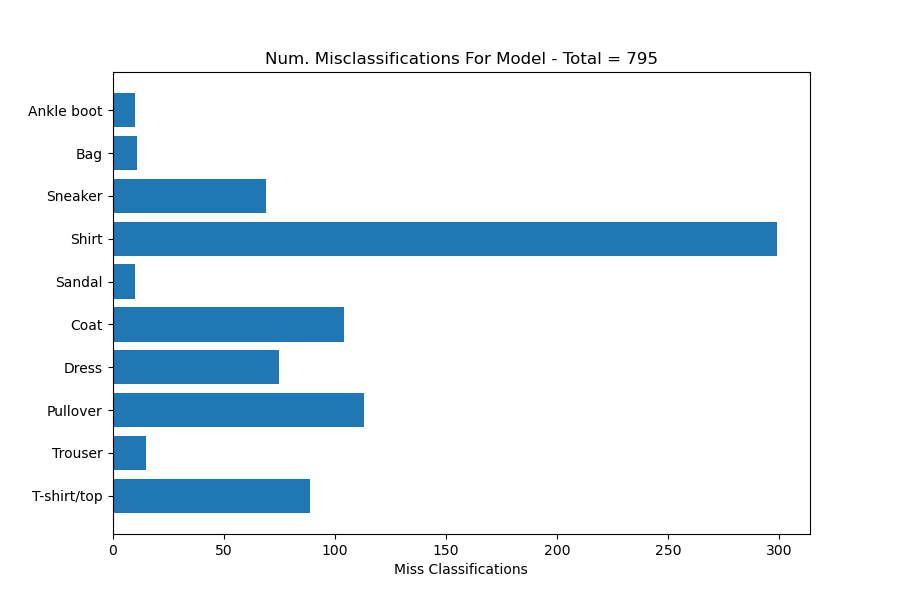

<IPython.core.display.Javascript object>


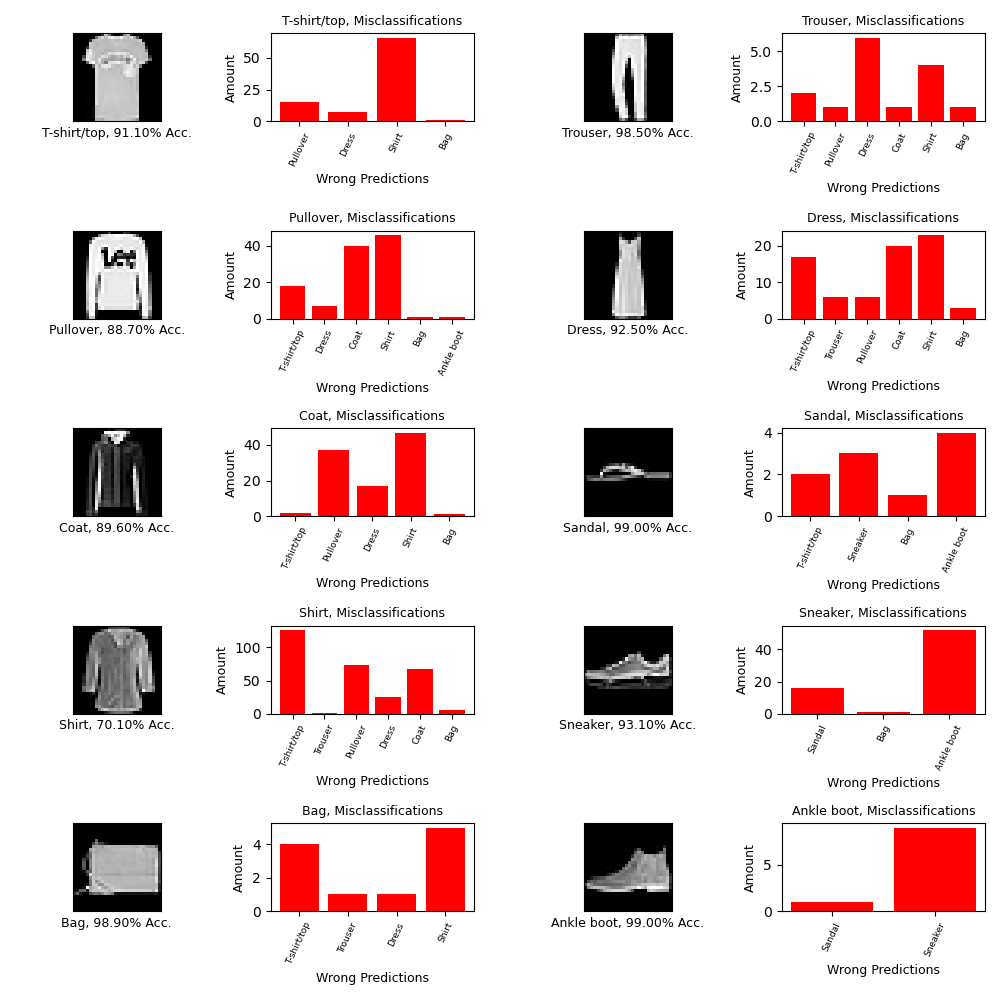

0

In [17]:
mis_cls_stats(preds1, y_test)

The model gave 9163 correct and 837 wrong predictions giving
an error rate of 0.9163 and an accuracy rate of 0.0837 

Label/class T-shirt/top was miss labeled/classified 110 times
So approximately 13.14% of the misslabels were for T-shirt/top
the accuracy rate for the T-shirt/top alone was 89.00%

Label/class Trouser was miss labeled/classified 5 times
So approximately 0.60% of the misslabels were for Trouser
the accuracy rate for the Trouser alone was 99.50%

Label/class Pullover was miss labeled/classified 110 times
So approximately 13.14% of the misslabels were for Pullover
the accuracy rate for the Pullover alone was 89.00%

Label/class Dress was miss labeled/classified 72 times
So approximately 8.60% of the misslabels were for Dress
the accuracy rate for the Dress alone was 92.80%

Label/class Coat was miss labeled/classified 97 times
So approximately 11.59% of the misslabels were for Coat
the accuracy rate for the Coat alone was 90.30%

Label/class Sandal was miss labeled/classif

<IPython.core.display.Javascript object>


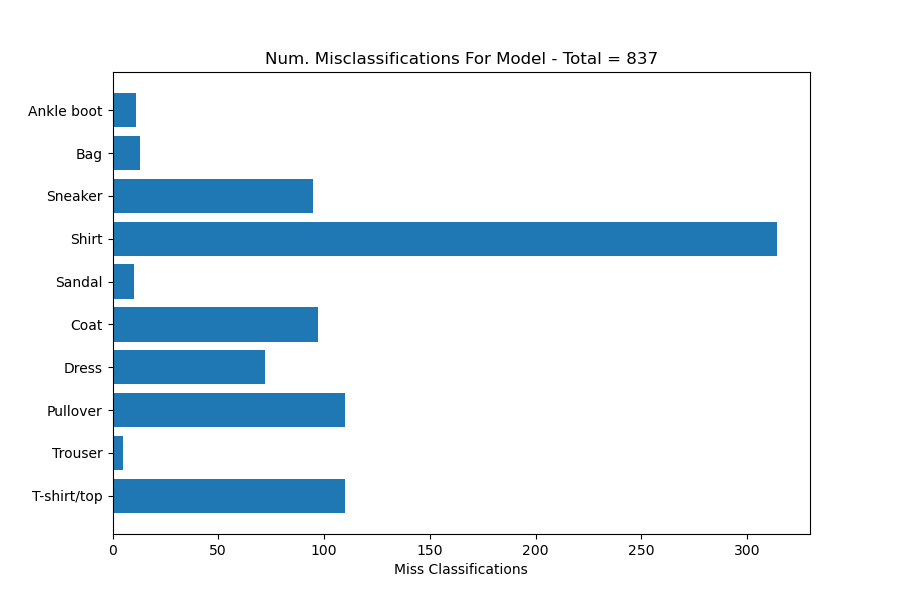

<IPython.core.display.Javascript object>


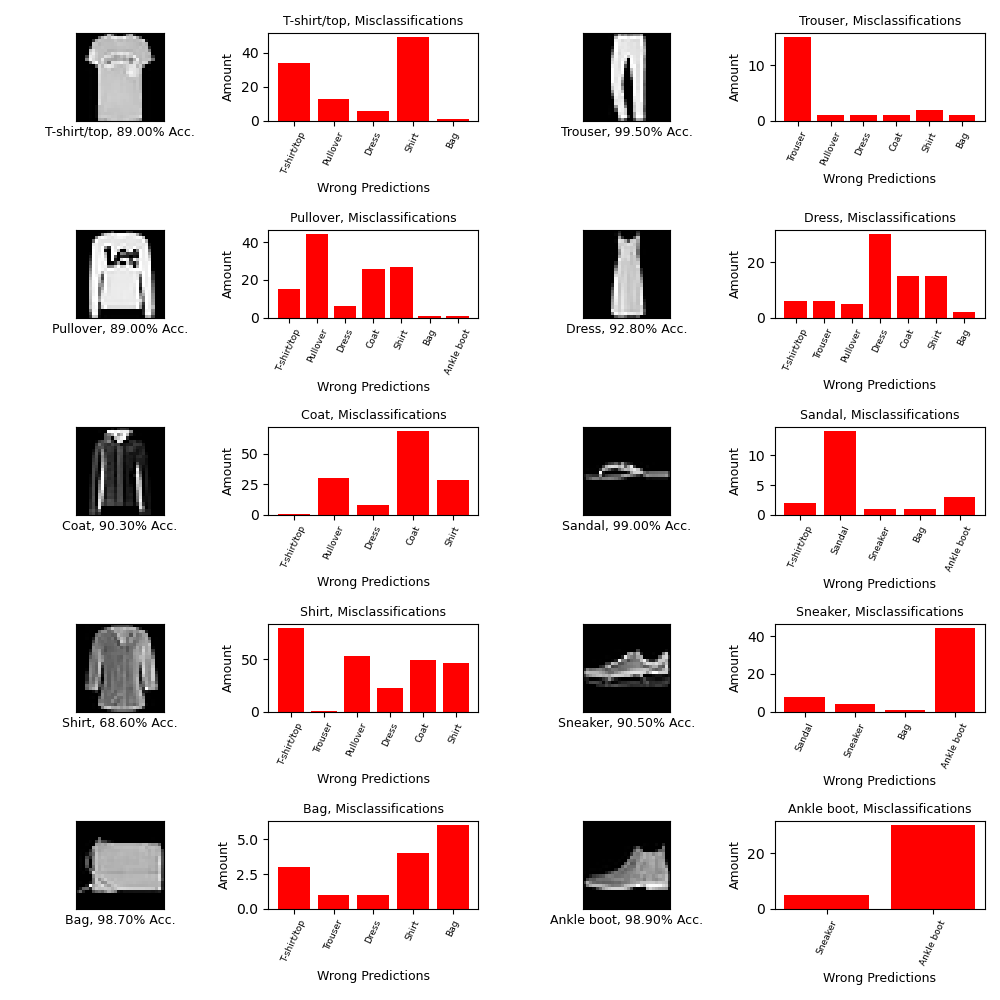

0

In [18]:
mis_cls_stats(preds2, y_test)

The model gave 9149 correct and 851 wrong predictions giving
an error rate of 0.9149 and an accuracy rate of 0.0851 

Label/class T-shirt/top was miss labeled/classified 86 times
So approximately 10.11% of the misslabels were for T-shirt/top
the accuracy rate for the T-shirt/top alone was 91.40%

Label/class Trouser was miss labeled/classified 14 times
So approximately 1.65% of the misslabels were for Trouser
the accuracy rate for the Trouser alone was 98.60%

Label/class Pullover was miss labeled/classified 83 times
So approximately 9.75% of the misslabels were for Pullover
the accuracy rate for the Pullover alone was 91.70%

Label/class Dress was miss labeled/classified 75 times
So approximately 8.81% of the misslabels were for Dress
the accuracy rate for the Dress alone was 92.50%

Label/class Coat was miss labeled/classified 200 times
So approximately 23.50% of the misslabels were for Coat
the accuracy rate for the Coat alone was 80.00%

Label/class Sandal was miss labeled/classifi

<IPython.core.display.Javascript object>


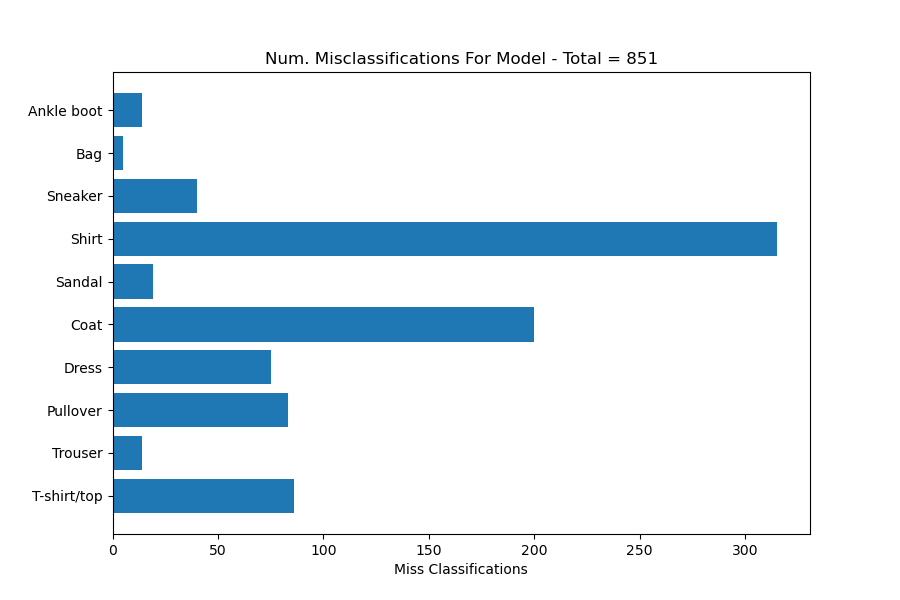

<IPython.core.display.Javascript object>


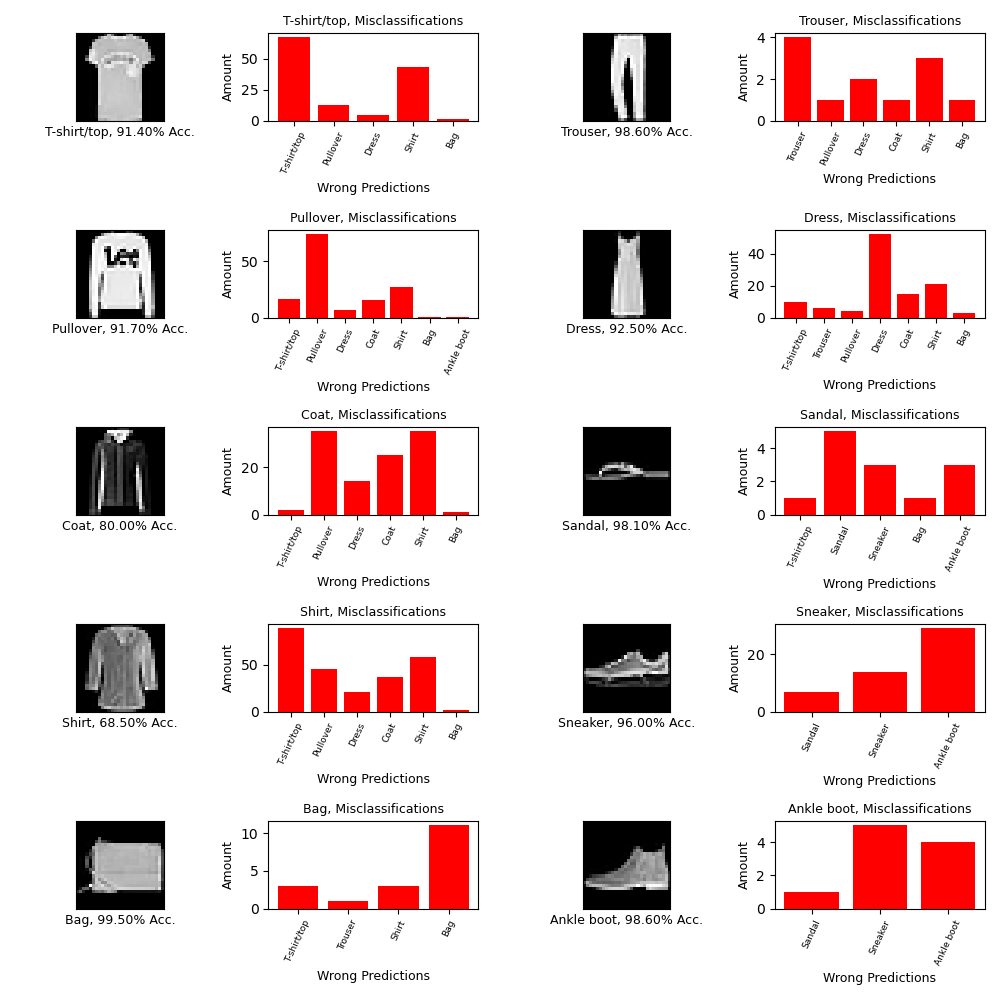

0

In [19]:
mis_cls_stats(preds3, y_test)

The model gave 9169 correct and 831 wrong predictions giving
an error rate of 0.9169 and an accuracy rate of 0.0831 

Label/class T-shirt/top was miss labeled/classified 186 times
So approximately 22.38% of the misslabels were for T-shirt/top
the accuracy rate for the T-shirt/top alone was 81.40%

Label/class Trouser was miss labeled/classified 14 times
So approximately 1.68% of the misslabels were for Trouser
the accuracy rate for the Trouser alone was 98.60%

Label/class Pullover was miss labeled/classified 155 times
So approximately 18.65% of the misslabels were for Pullover
the accuracy rate for the Pullover alone was 84.50%

Label/class Dress was miss labeled/classified 69 times
So approximately 8.30% of the misslabels were for Dress
the accuracy rate for the Dress alone was 93.10%

Label/class Coat was miss labeled/classified 172 times
So approximately 20.70% of the misslabels were for Coat
the accuracy rate for the Coat alone was 82.80%

Label/class Sandal was miss labeled/class

<IPython.core.display.Javascript object>


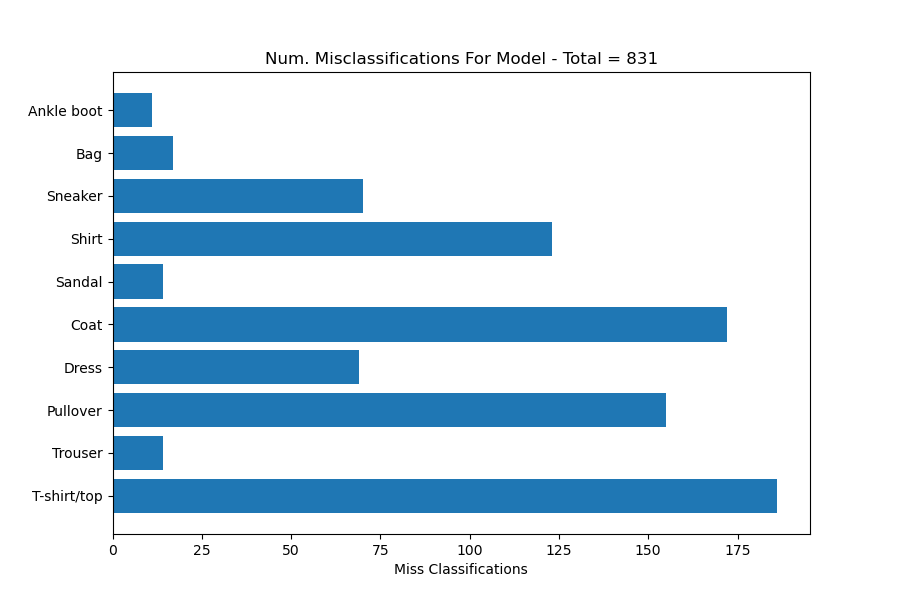

<IPython.core.display.Javascript object>


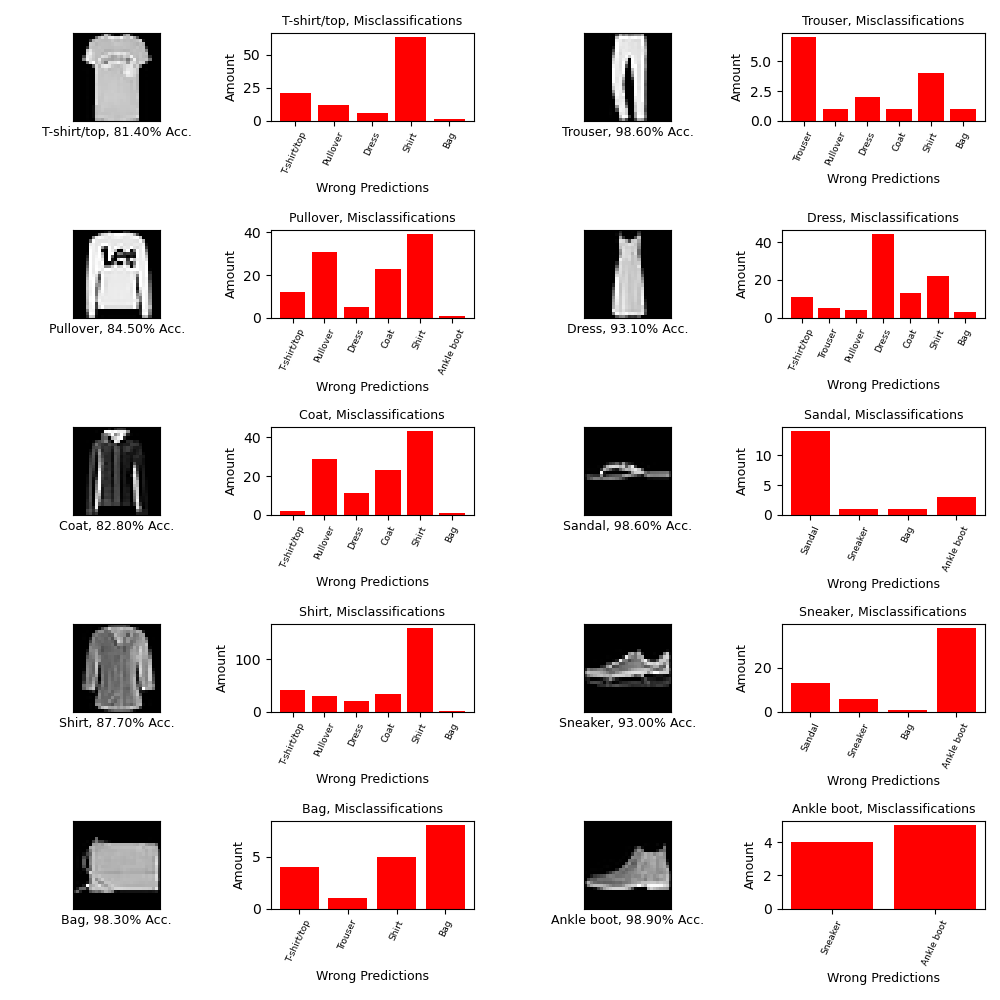

0

In [20]:
mis_cls_stats(preds4, y_test)